In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

import config

load dataset

In [2]:
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

In [3]:
df = pd.read_csv('../Data/preprocessed_data.csv')
df.head()

,datetime,machineID,Type,Air_temperature,Process_temperature,Rotational_speed,Torque,Tool_wear,Target,RUL_hours,Failure_Type,month,hour,dayofweek
0,2015-03-19 20:05:05,228,H,295.0,305.0,1497,40.2,118,0,20744,No Failure,3,20,3
1,2015-06-16 09:27:48,201,H,295.0,305.0,1494,41.0,246,0,18040,No Failure,6,9,1
2,2017-02-08 16:01:14,29,L,310.0,320.0,1428,64.7,300,0,656,No Failure,2,16,2
3,2016-02-17 00:18:19,83,M,302.1,313.4,1472,45.2,300,0,8192,No Failure,2,0,2
4,2015-04-09 23:11:44,205,M,300.2,310.3,1497,40.4,148,0,19304,No Failure,4,23,3


In [4]:
# statistical summary
print("\nNumeric Features Statistics:")
print(df.describe())

print("\nCategorical Features:")
for col in df.select_dtypes(include=['object', 'category']).columns:
    print(f"\n{col}:")
    print(df[col].value_counts())


Numeric Features Statistics:
           machineID  Air_temperature  Process_temperature  Rotational_speed  \
count  100000.000000    100000.000000        100000.000000     100000.000000   
mean      167.546840       303.772080           314.891460       1436.255490   
std       105.147196         5.553468             5.900532         47.305605   
min         1.000000       295.000000           305.000000       1272.000000   
25%        80.000000       300.300000           310.500000       1429.000000   
50%       160.000000       304.400000           317.300000       1438.000000   
75%       239.000000       310.000000           320.000000       1463.000000   
max       400.000000       310.000000           320.000000       1503.000000   

              Torque      Tool_wear         Target      RUL_hours  \
count  100000.000000  100000.000000  100000.000000  100000.000000   
mean       50.060780     288.413630       0.002500    6905.226400   
std         8.009187      46.877092       

Distribution Analysis

Distribution plots saved


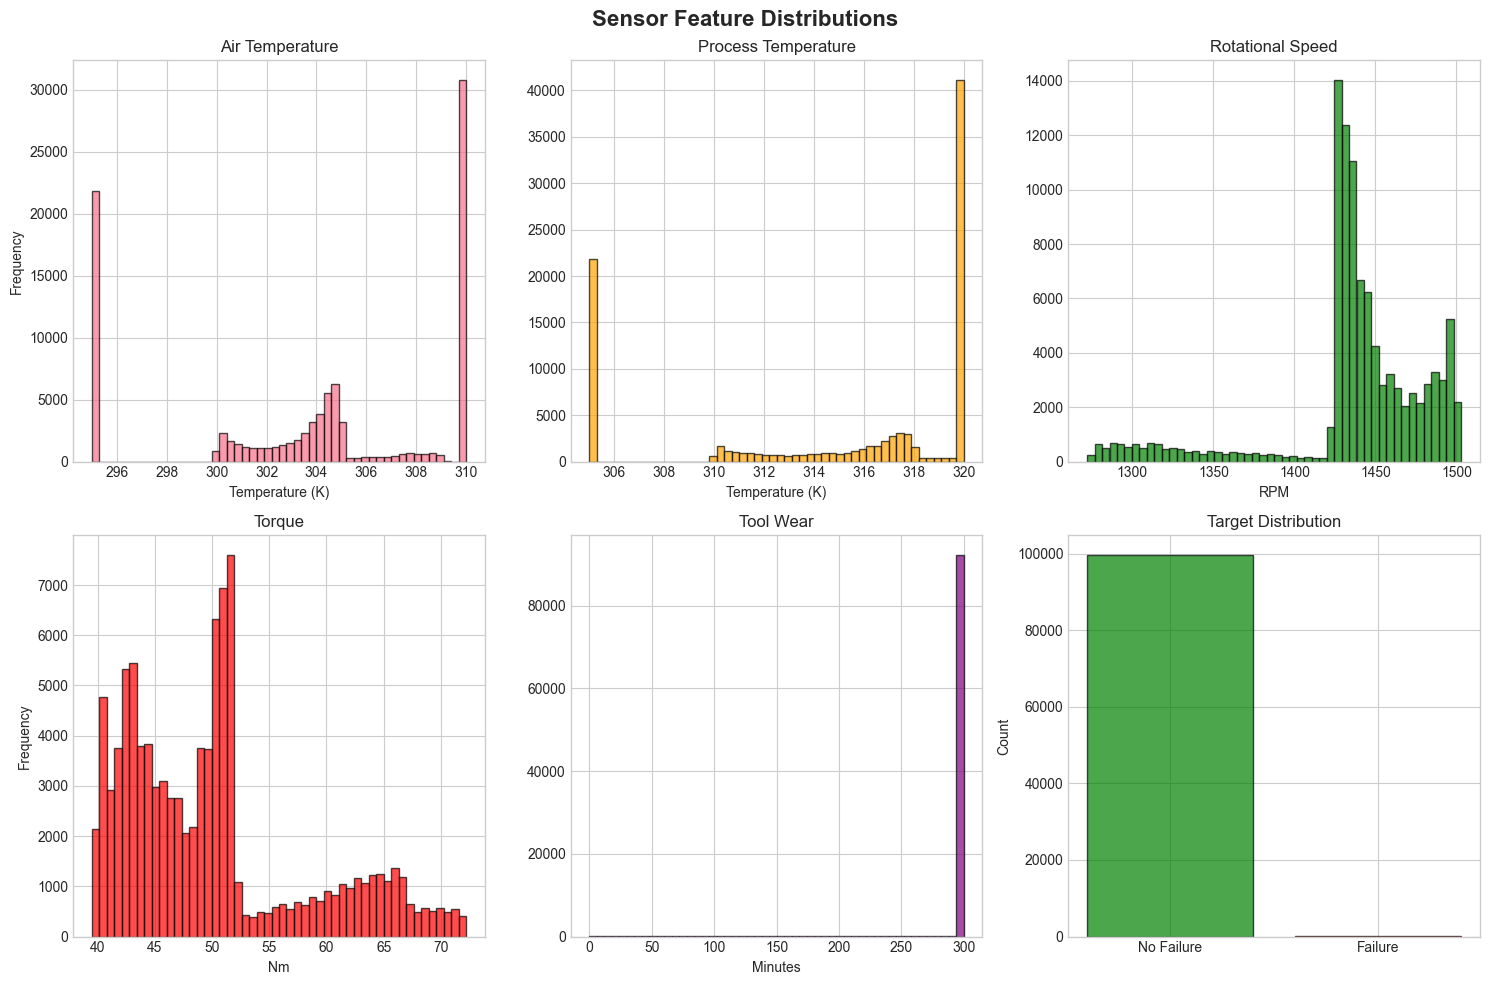

In [5]:
# Create figure for distributions
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Sensor Feature Distributions', fontsize=16, fontweight='bold')

# Plot distributions
if 'Air_temperature' in df.columns:
    axes[0, 0].hist(df['Air_temperature'], bins=50, edgecolor='black', alpha=0.7)
    axes[0, 0].set_title('Air Temperature')
    axes[0, 0].set_xlabel('Temperature (K)')
    axes[0, 0].set_ylabel('Frequency')

if 'Process_temperature' in df.columns:
    axes[0, 1].hist(df['Process_temperature'], bins=50, edgecolor='black', alpha=0.7, color='orange')
    axes[0, 1].set_title('Process Temperature')
    axes[0, 1].set_xlabel('Temperature (K)')
    
if 'Rotational_speed' in df.columns:
    axes[0, 2].hist(df['Rotational_speed'], bins=50, edgecolor='black', alpha=0.7, color='green')
    axes[0, 2].set_title('Rotational Speed')
    axes[0, 2].set_xlabel('RPM')

if 'Torque' in df.columns:
    axes[1, 0].hist(df['Torque'], bins=50, edgecolor='black', alpha=0.7, color='red')
    axes[1, 0].set_title('Torque')
    axes[1, 0].set_xlabel('Nm')
    axes[1, 0].set_ylabel('Frequency')

if 'Tool_wear' in df.columns:
    axes[1, 1].hist(df['Tool_wear'], bins=50, edgecolor='black', alpha=0.7, color='purple')
    axes[1, 1].set_title('Tool Wear')
    axes[1, 1].set_xlabel('Minutes')

if 'Target' in df.columns:
    target_counts = df['Target'].value_counts()
    axes[1, 2].bar(['No Failure', 'Failure'], target_counts.values, 
                   color=['green', 'red'], alpha=0.7, edgecolor='black')
    axes[1, 2].set_title('Target Distribution')
    axes[1, 2].set_ylabel('Count')

plt.tight_layout()

plt.savefig('../Output/distributions.png', dpi=100, bbox_inches='tight')
    
print("Distribution plots saved")

Correlation Analysis

Correlation matrix saved


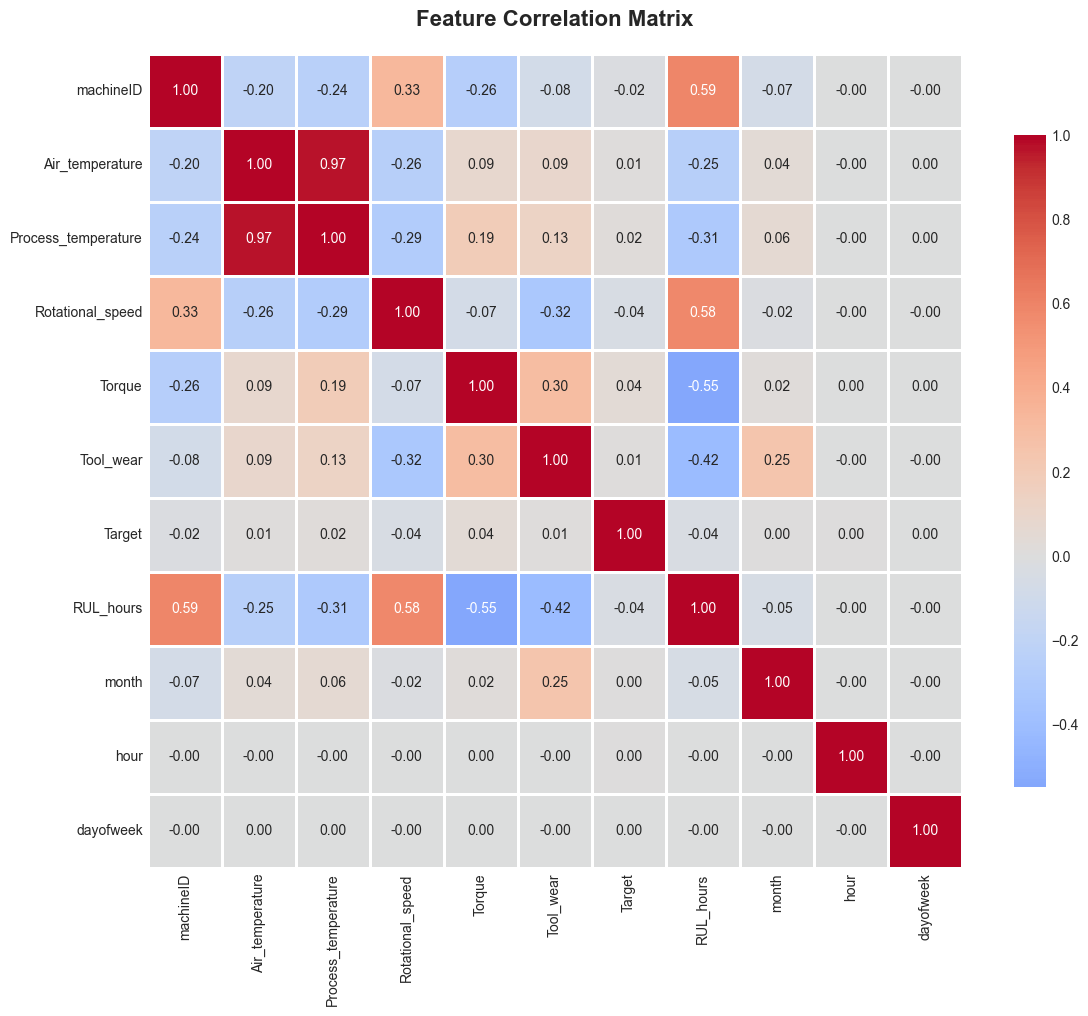

In [6]:
# Select numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Calculate correlation matrix
corr_matrix = df[numeric_cols].corr()

# Plot correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Matrix', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()

plt.savefig('../Output/correlation_matrix.png', dpi=100, bbox_inches='tight')

print("Correlation matrix saved")

In [7]:
print("\nHigh Correlations (|r| > 0.5):")
high_corr = corr_matrix.abs() > 0.5
for i in range(len(corr_matrix)):
    for j in range(i+1, len(corr_matrix)):
        if high_corr.iloc[i, j]:
            print(f"   {corr_matrix.index[i]} <-> {corr_matrix.columns[j]}: {corr_matrix.iloc[i, j]:.3f}")



High Correlations (|r| > 0.5):
   machineID <-> RUL_hours: 0.589
   Air_temperature <-> Process_temperature: 0.965
   Rotational_speed <-> RUL_hours: 0.581
   Torque <-> RUL_hours: -0.548


Target Analysis


Overall Failure Rate: 0.25%

Failure Rate by Machine Type:
      sum  count      mean  failure_rate
Type                                    
H      44  21872  0.002012      0.201170
L      84  30834  0.002724      0.272427
M     122  47294  0.002580      0.257961
Failure analysis plots saved


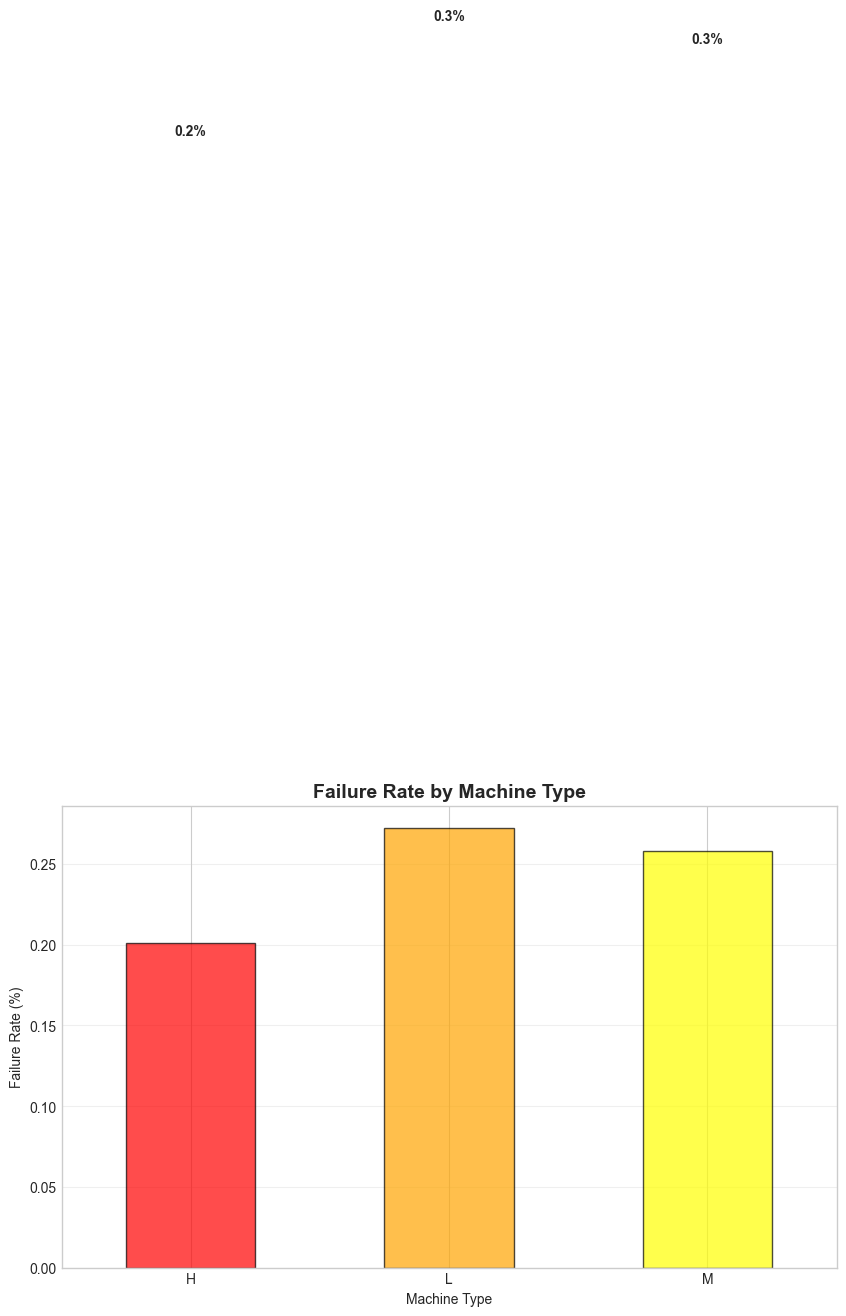

In [8]:
if 'Target' in df.columns:
    # Failure rate
    failure_rate = df['Target'].mean() * 100
    print(f"\nOverall Failure Rate: {failure_rate:.2f}%")
    
    # Failure by type
    if 'Type' in df.columns:
        failure_by_type = df.groupby('Type')['Target'].agg(['sum', 'count', 'mean'])
        failure_by_type['failure_rate'] = failure_by_type['mean'] * 100
        print("\nFailure Rate by Machine Type:")
        print(failure_by_type)
    
    # Plot failure by type
    if 'Type' in df.columns:
        plt.figure(figsize=(10, 6))
        failure_by_type['failure_rate'].plot(kind='bar', color=['red', 'orange', 'yellow'], 
                                             edgecolor='black', alpha=0.7)
        plt.title('Failure Rate by Machine Type', fontsize=14, fontweight='bold')
        plt.xlabel('Machine Type')
        plt.ylabel('Failure Rate (%)')
        plt.xticks(rotation=0)
        plt.grid(True, alpha=0.3, axis='y')
        
        # Add value labels
        for i, v in enumerate(failure_by_type['failure_rate']):
            plt.text(i, v + 0.5, f'{v:.1f}%', ha='center', fontweight='bold')
        
        plt.tight_layout()
        

        plt.savefig('../Output/failure_by_type.png', dpi=100, bbox_inches='tight')
        
        print("Failure analysis plots saved")

Failure Type analysis


Failure Types:
   Heat Dissipation Failure: 68 (27.2%)
   Tool Wear Failure: 51 (20.4%)
   Power Failure: 48 (19.2%)
   Overstrain Failure: 47 (18.8%)
   Random Failures: 36 (14.4%)
Failure type plots saved


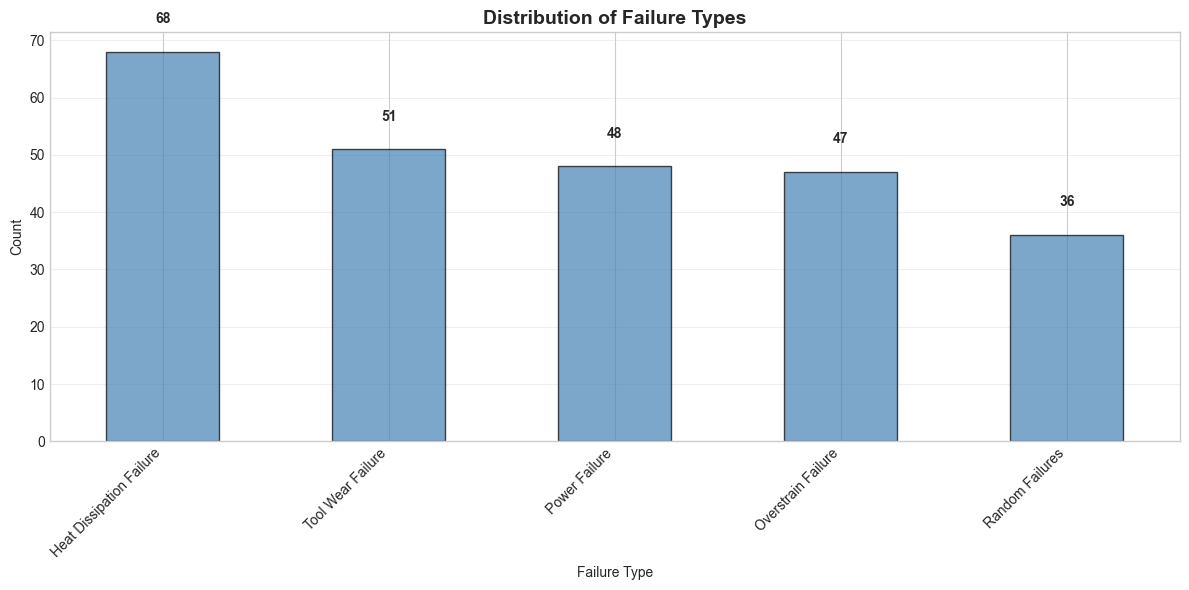

In [9]:
if 'Failure_Type' in df.columns:
    failure_types = df[df['Failure_Type'] != 'No Failure']['Failure_Type'].value_counts()
    
    print("\nFailure Types:")
    for ftype, count in failure_types.items():
        pct = count / len(df[df['Failure_Type'] != 'No Failure']) * 100
        print(f"   {ftype}: {count} ({pct:.1f}%)")
    
    # Plot failure types
    plt.figure(figsize=(12, 6))
    failure_types.plot(kind='bar', color='steelblue', edgecolor='black', alpha=0.7)
    plt.title('Distribution of Failure Types', fontsize=14, fontweight='bold')
    plt.xlabel('Failure Type')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for i, v in enumerate(failure_types.values):
        plt.text(i, v + 5, str(v), ha='center', fontweight='bold')
    
    plt.tight_layout()
    

    plt.savefig('../Output/failure_types.png', dpi=100, bbox_inches='tight')
    
    print("Failure type plots saved")

Outlier detection

In [10]:
# Detect outliers using IQR method
outlier_summary = {}

# Define sensor features 
sensor_features = ['Air_temperature', 'Process_temperature', 'Rotational_speed', 'Torque', 'Tool_wear']

for col in sensor_features:
    if col in df.columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        outlier_summary[col] = {
            'count': len(outliers),
            'percentage': len(outliers) / len(df) * 100,
            'lower_bound': lower_bound,
            'upper_bound': upper_bound
        }

print("\nOutlier Detection (IQR Method):")
for col, info in outlier_summary.items():
    print(f"\n{col}:")
    print(f"   Outliers: {info['count']} ({info['percentage']:.2f}%)")
    print(f"   Bounds: [{info['lower_bound']:.2f}, {info['upper_bound']:.2f}]")


Outlier Detection (IQR Method):

Air_temperature:
   Outliers: 0 (0.00%)
   Bounds: [285.75, 324.55]

Process_temperature:
   Outliers: 0 (0.00%)
   Bounds: [296.25, 334.25]

Rotational_speed:
   Outliers: 10374 (10.37%)
   Bounds: [1378.00, 1514.00]

Torque:
   Outliers: 9337 (9.34%)
   Bounds: [31.05, 64.25]

Tool_wear:
   Outliers: 7835 (7.83%)
   Bounds: [300.00, 300.00]


Feature Relationship

In [11]:
if 'Target' in df.columns:
    # Compare failed vs non-failed machines
    print("\nFailed vs Non-Failed Machines:")
    
    for col in sensor_features:
        if col in df.columns:
            failed = df[df['Target'] == 1][col]
            normal = df[df['Target'] == 0][col]
            
            if len(failed) > 0:
                print(f"\n{col}:")
                print(f"   Normal: mean={normal.mean():.2f}, std={normal.std():.2f}")
                print(f"   Failed: mean={failed.mean():.2f}, std={failed.std():.2f}")
                
                # Statistical test
                t_stat, p_value = stats.ttest_ind(failed, normal)
                if p_value < 0.05:
                    print(f"   Significant difference (p={p_value:.4f})")


Failed vs Non-Failed Machines:

Air_temperature:
   Normal: mean=303.77, std=5.55
   Failed: mean=305.39, std=5.28
   Significant difference (p=0.0000)

Process_temperature:
   Normal: mean=314.89, std=5.90
   Failed: mean=316.84, std=5.55
   Significant difference (p=0.0000)

Rotational_speed:
   Normal: mean=1436.36, std=47.23
   Failed: mean=1395.70, std=59.17
   Significant difference (p=0.0000)

Torque:
   Normal: mean=50.04, std=7.99
   Failed: mean=56.90, std=10.80
   Significant difference (p=0.0000)

Tool_wear:
   Normal: mean=288.38, std=46.93
   Failed: mean=300.00, std=0.00
   Significant difference (p=0.0001)
